# Predicting Building Damage

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

In [2]:
# !pip install category-encoders

## Read datasets

In [3]:
structure = pd.read_csv('./nepal_earthquke_full_dataset/csv_building_structure.csv', low_memory=False)

# Exploratory Data Analyses (EDA)

## Inspect the Data: Structure and Characteristics

In [4]:
structure.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
0,120101000011,12,1207,120703,1,1,9,288,9,9,...,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
1,120101000021,12,1207,120703,1,1,15,364,9,9,...,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
2,120101000031,12,1207,120703,1,1,20,384,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
3,120101000041,12,1207,120703,1,1,20,312,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
4,120101000051,12,1207,120703,1,1,30,308,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair


In [5]:
structure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             762106 non-null  int64 
 1   district_id                             762106 non-null  int64 
 2   vdcmun_id                               762106 non-null  int64 
 3   ward_id                                 762106 non-null  int64 
 4   count_floors_pre_eq                     762106 non-null  int64 
 5   count_floors_post_eq                    762106 non-null  int64 
 6   age_building                            762106 non-null  int64 
 7   plinth_area_sq_ft                       762106 non-null  int64 
 8   height_ft_pre_eq                        762106 non-null  int64 
 9   height_ft_post_eq                       762106 non-null  int64 
 10  land_surface_condition                  762106 non-null 

## Data Preparation and Cleaning

In [6]:
structure.isnull().sum()

building_id                                0
district_id                                0
vdcmun_id                                  0
ward_id                                    0
count_floors_pre_eq                        0
count_floors_post_eq                       0
age_building                               0
plinth_area_sq_ft                          0
height_ft_pre_eq                           0
height_ft_post_eq                          0
land_surface_condition                     0
foundation_type                            0
roof_type                                  0
ground_floor_type                          0
other_floor_type                           0
position                                   1
plan_configuration                         1
has_superstructure_adobe_mud               0
has_superstructure_mud_mortar_stone        0
has_superstructure_stone_flag              0
has_superstructure_cement_mortar_stone     0
has_superstructure_mud_mortar_brick        0
has_supers

From the info above we can see the data has very few missing values hence we can safely drop rows with missing values without losing too much information.

In [7]:
def wrangle(df):
    
    #Remove unneccessary and leaky features (columns) 
    drop_cols = [col for col in df.columns if 'post_eq' in col]
    df = df.drop(columns=drop_cols)
    df = df.drop(columns=['building_id','district_id',
                     'vdcmun_id',
                     'ward_id',
                     'technical_solution_proposed'])
    #drop rows with null/missing values
    df = df.dropna()
    
    return df

In [8]:
structure.shape

(762106, 31)

In [9]:
clean_df = wrangle(structure)
clean_df.shape

(762094, 23)

## Inspect and Correct data types

In [10]:
clean_df.dtypes

count_floors_pre_eq                        int64
age_building                               int64
plinth_area_sq_ft                          int64
height_ft_pre_eq                           int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_timber                  int64
has_superstructure_bamboo                  int64
has_superstructure_rc_non_engineered       int64
has_superstructure_r

## Inspect if there are still null/missing values 


In [11]:
clean_df.isnull().sum()

count_floors_pre_eq                       0
age_building                              0
plinth_area_sq_ft                         0
height_ft_pre_eq                          0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engineered      0
has_superstructure_rc_engineered          0
has_superstructure_other                  0
damage_grade                    

In [12]:
clean_df.shape

(762094, 23)

In [13]:
structure.shape

(762106, 31)

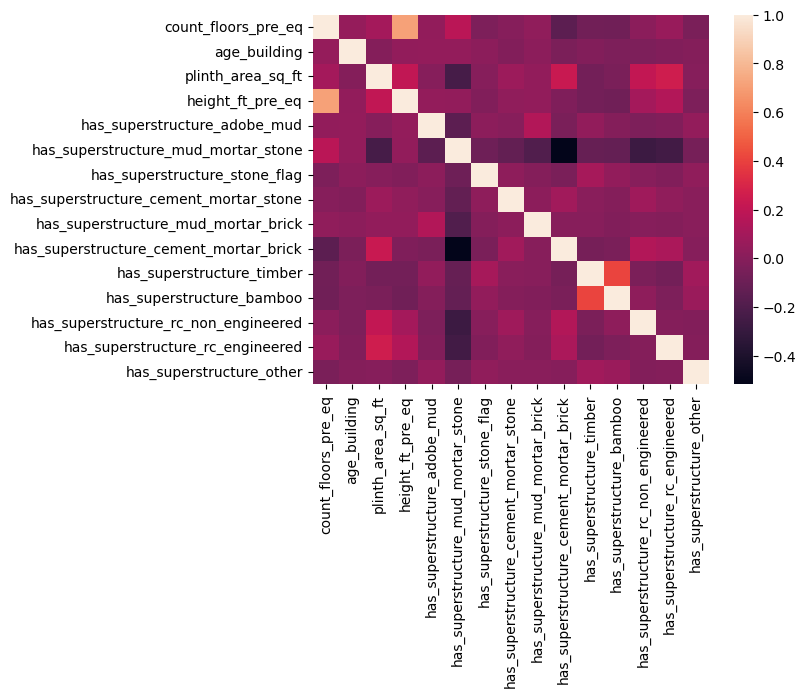

In [14]:
# Damage grade (and any other non-numeric feature) is automatically ignored in the correlation matrix since it is currently non-numeric. 
# So we don't have to manually remove it for this multicollinearity test
correlation = clean_df.corr()
sns.heatmap(correlation);

# Engineer a new damage grade numeric feature

In [15]:
grades = clean_df['damage_grade'].unique().tolist()

In [16]:
grades = ['Grade 1','Grade 2','Grade 3','Grade 4', 'Grade 5']

In [17]:
clean_df['damage_grade'] = pd.Categorical(clean_df['damage_grade'], categories=grades, ordered=True)

In [18]:
clean_df[clean_df['damage_grade'] > 'Grade 4']

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade
1,1,15,364,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,1,0,0,0,Grade 5
6,1,13,234,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,Grade 5
39,1,60,348,12,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,Grade 5
44,2,40,288,15,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,...,0,0,0,0,0,0,0,0,0,Grade 5
61,2,20,336,21,Steep slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,...,0,0,0,0,0,0,0,0,0,Grade 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,2,60,165,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-2 side,...,0,0,0,0,0,0,0,0,0,Grade 5
762102,2,35,342,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-1 side,...,0,0,0,0,0,0,0,0,0,Grade 5
762103,2,35,342,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,...,0,0,0,0,0,0,0,0,0,Grade 5
762104,2,19,306,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,...,0,0,0,0,0,0,0,0,0,Grade 5


In [19]:
clean_df.loc[clean_df['damage_grade'] > 'Grade 3', 'severe_damage'] = 1 # signifying true for Severe damage

In [20]:
clean_df.loc[clean_df['damage_grade'] <= 'Grade 3', 'severe_damage'] = 0 # signifying false for Severe damage

In [21]:
clean_df['severe_damage'].value_counts()

1.0    459610
0.0    302484
Name: severe_damage, dtype: int64

In [22]:
assert clean_df.shape[0] == 459610 + 302484

In [23]:
clean_df.drop(columns=['damage_grade'], inplace=True) # drop damage grade since we now have the bolean severe damage target variable

In [24]:
clean_df['severe_damage'] = clean_df['severe_damage'].astype('int')

In [25]:
clean_df.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,severe_damage
0,1,9,288,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,1,0,0,0,0
1,1,15,364,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,1,0,0,0,1
2,1,20,384,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,0
3,1,20,312,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,0
4,1,30,308,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,0


## Remove columns with multicollinearity

In [26]:
clean_df['severe_damage'].corr(clean_df['count_floors_pre_eq'])
# has way more effect on the target variable hence important to keep

0.16904872399965754

In [27]:
clean_df['severe_damage'].corr(clean_df['height_ft_pre_eq'])

0.04911364038144871

In [28]:
clean_df['severe_damage'].corr(clean_df['has_superstructure_bamboo'])

-0.10231412644880877

In [29]:
clean_df['severe_damage'].corr(clean_df['has_superstructure_timber']) 
# slightly has more effect on the target variable hence important to keep 

-0.1027526329853448

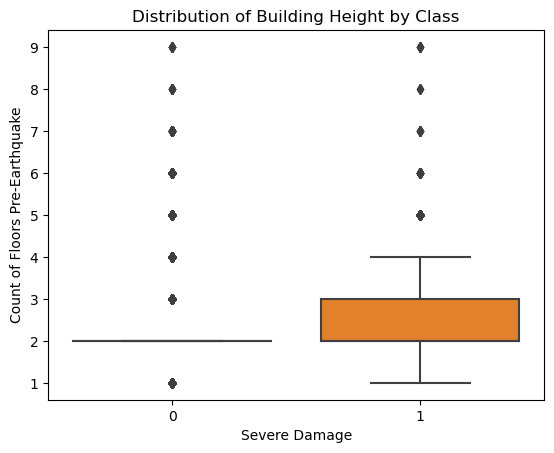

In [30]:
sns.boxplot(x='severe_damage', y='count_floors_pre_eq', data=clean_df)
plt.title('Distribution of Building Height by Class')
plt.ylabel('Count of Floors Pre-Earthquake')
plt.xlabel('Severe Damage');

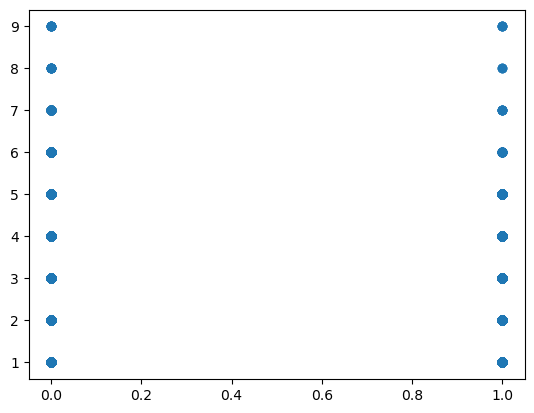

In [31]:
plt.scatter(clean_df['severe_damage'], clean_df['count_floors_pre_eq']);

In [32]:
# Outliers are not good for regression

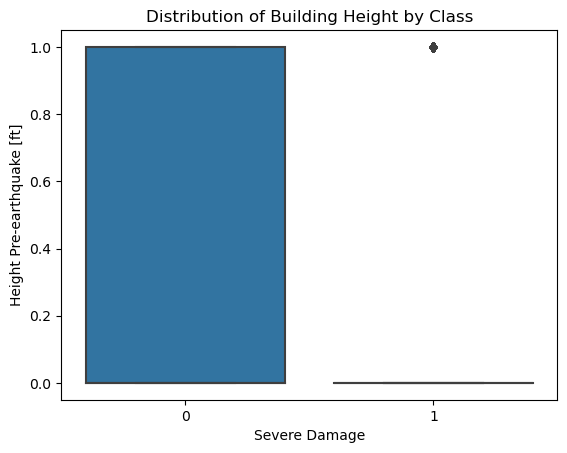

In [33]:
sns.boxplot(x='severe_damage', y='has_superstructure_timber', data=clean_df)
plt.title('Distribution of Building Height by Class')
plt.ylabel('Height Pre-earthquake [ft]')
plt.xlabel('Severe Damage');

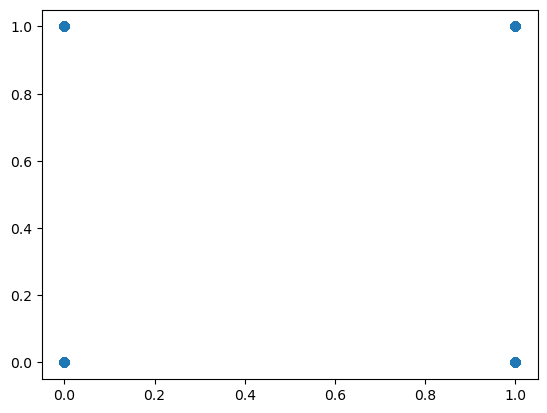

In [34]:
plt.scatter(clean_df['has_superstructure_timber'], clean_df['severe_damage']);
# may need to collapse the superstructure column into and code each type uniquely

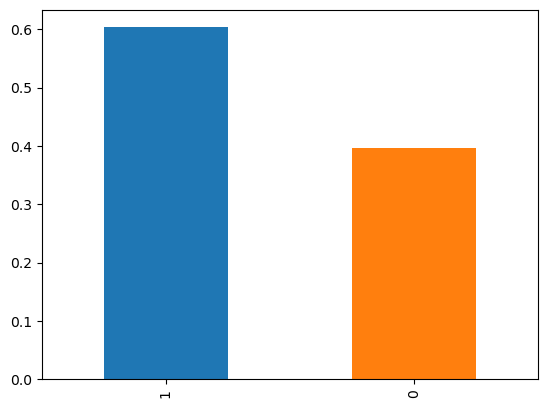

In [35]:
clean_df['severe_damage'].value_counts(normalize=True).plot(
    kind='bar',
    color=['C0', 'C1']
);

In [36]:
foundation_pivot = pd.pivot_table(clean_df, 
                                  index='foundation_type', 
                                  values='severe_damage', 
                                  aggfunc=np.mean
                                 ).sort_values(by='severe_damage')

In [37]:
foundation_pivot

,severe_damage
foundation_type,
RC,0.038263
Bamboo/Timber,0.237855
Cement-Stone/Brick,0.296904
Other,0.510545
Mud mortar-Stone/Brick,0.685115


In [38]:
foundation_pivot

,severe_damage
foundation_type,
RC,0.038263
Bamboo/Timber,0.237855
Cement-Stone/Brick,0.296904
Other,0.510545
Mud mortar-Stone/Brick,0.685115


In [39]:
majority_class_prop, mainority_class_prop = clean_df['severe_damage'].value_counts(normalize=True)

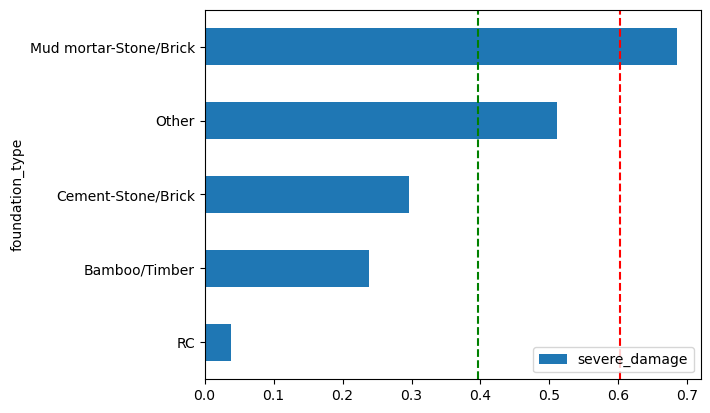

In [40]:
foundation_pivot.plot(kind='barh')
plt.axvline(majority_class_prop, linestyle='--', color='red')
plt.axvline(mainority_class_prop, linestyle='--', color='green')
plt.legend(loc='lower right');

In [41]:
# Hi lo cardinaltiy categorical values

In [42]:
clean_df.select_dtypes('object').nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
dtype: int64

In [43]:
target = 'severe_damage'
X = clean_df.drop(columns=target)
y = clean_df[target]

In [44]:
scaler = MinMaxScaler()

In [46]:
enc = OneHotEncoder(use_cat_names=True)

In [47]:
X = enc.fit_transform(X)
X.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition_Flat,land_surface_condition_Moderate slope,land_surface_condition_Steep slope,foundation_type_Other,foundation_type_Mud mortar-Stone/Brick,foundation_type_Cement-Stone/Brick,...,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
0,1,9,288,9,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
1,1,15,364,9,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,1,20,384,9,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,20,312,9,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,30,308,9,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [48]:
X_scaled = scaler.fit_transform(X) # returns a numpy.ndarray

In [49]:
X_scaled[:2]

array([[0.        , 0.00900901, 0.04421907, 0.03225806, 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01501502, 0.05963489, 0.03225806, 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1. 

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [51]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (609675, 49)
y_train shape: (609675,)
X_test shape: (152419, 49)
y_test shape: (152419,)


# Model Building

## Baseline Model

In [52]:
acc_baseline = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', round(acc_baseline, 2))

Baseline Accuracy: 0.6


## Logistics Regression Model

In [ ]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)

In [60]:
model = LogisticRegression(max_iter=1000)

In [61]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Model Evaluation

In [62]:
# two methods of calculating accuracy are demonstrated below

acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test) # returns accuracy score by default
print('Training Accuracy:',acc_train)
print('Test Accuracy:', acc_test)

Training Accuracy: 0.7315504162053553
Test Accuracy: 0.7305716478916671


The Logistic Regression accuracy beats the baseline model accuracy, however, training accuracy is slightly hihger than test accuracy meaning there is a hint of overfitting

In [ ]:
clean_df.head()

In [ ]:
clean_df['land_surface_condition'].value_counts()

In [53]:
X_train.shape

(609675, 49)

# Deep Neural Network

## Model building

In [54]:
# create model
model_deep = Sequential()
model_deep.add(Dense(60, input_shape=(X_train.shape[1],), activation='relu'))
model_deep.add(Dense(1, activation='sigmoid'))
# Compile model
model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
model_deep.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                3000      
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 3,061
Trainable params: 3,061
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model_deep.fit(X_train, y_train , verbose=2, epochs=50, batch_size=20, validation_split=0.2) #callbacks=[es]

Epoch 1/50
19053/19053 - 43s - loss: 0.5473 - accuracy: 0.7342 - 43s/epoch - 2ms/step
Epoch 2/50
19053/19053 - 41s - loss: 0.5400 - accuracy: 0.7379 - 41s/epoch - 2ms/step
Epoch 3/50
19053/19053 - 41s - loss: 0.5375 - accuracy: 0.7385 - 41s/epoch - 2ms/step
Epoch 4/50
19053/19053 - 41s - loss: 0.5359 - accuracy: 0.7398 - 41s/epoch - 2ms/step
Epoch 5/50
19053/19053 - 41s - loss: 0.5348 - accuracy: 0.7403 - 41s/epoch - 2ms/step
Epoch 6/50
19053/19053 - 42s - loss: 0.5338 - accuracy: 0.7408 - 42s/epoch - 2ms/step
Epoch 7/50
19053/19053 - 41s - loss: 0.5334 - accuracy: 0.7412 - 41s/epoch - 2ms/step
Epoch 8/50
19053/19053 - 41s - loss: 0.5327 - accuracy: 0.7415 - 41s/epoch - 2ms/step
Epoch 9/50
19053/19053 - 43s - loss: 0.5323 - accuracy: 0.7418 - 43s/epoch - 2ms/step
Epoch 10/50
19053/19053 - 47s - loss: 0.5318 - accuracy: 0.7418 - 47s/epoch - 2ms/step
Epoch 11/50
19053/19053 - 41s - loss: 0.5315 - accuracy: 0.7422 - 41s/epoch - 2ms/step
Epoch 12/50
19053/19053 - 41s - loss: 0.5313 - accur

In [88]:
from keras.models import load_model
import os
from datetime import datetime

In [89]:
folder_name = datetime.now().strftime('%d-%b-%Y')

os.makedirs('./saved_models/'+ folder_name) #this code should run once to avoid creating multiple folders

In [90]:
stamp = datetime.now().strftime('%Y-%m-%d %H.%M.%S')

stamp = stamp.replace(' ','_')
stamp = stamp.replace('.','_')

In [93]:
model_deep.save('./saved_models/'+ folder_name + '/model-deep-no-validation'+ stamp + '.h5')

## Model Evaluation

In [69]:
model_loss, model_accuracy = model_deep.evaluate(X_train, y_train)

19053/19053 [==============================] - 49s 3ms/step - loss: 0.5257 - accuracy: 0.7449


In [70]:
print('Training Accuracy:',model_accuracy)
print('Training Loss:',model_loss)

Training Accuracy: 0.7448558807373047
Training Loss: 0.5256690979003906


In [71]:
model_loss, model_accuracy = model_deep.evaluate(X_test, y_test)

4764/4764 [==============================] - 13s 3ms/step - loss: 0.5315 - accuracy: 0.7415


In [72]:
print('Test Accuracy:',model_accuracy)
print('Test Loss:',model_loss)

Test Accuracy: 0.7415479421615601
Test Loss: 0.5314754843711853


In [63]:
model_deep.predict(X_test)

4764/4764 [==============================] - 10s 2ms/step


array([[0.37317285],
       [0.6929326 ],
       [0.92414296],
       ...,
       [0.79975986],
       [0.5799401 ],
       [0.44062516]], dtype=float32)

In [67]:
y_pred = (model_deep.predict(X_test) > 0.5).astype('int32') #convert probabilities to classes

4764/4764 [==============================] - 11s 2ms/step


In [68]:
y_pred

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [75]:
np.array(y_test).reshape(-1,1)

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

## Communication of Results

In [79]:
cmatrix = confusion_matrix(y_test, y_pred)

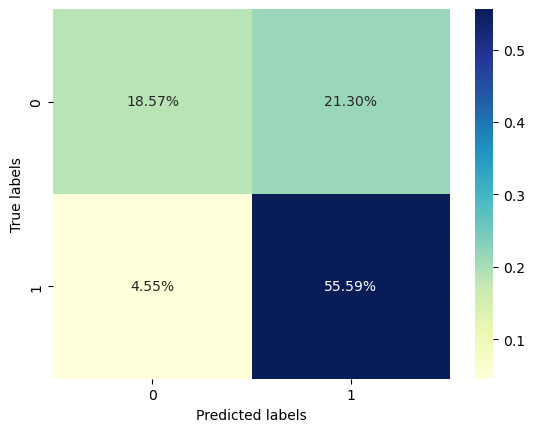

In [81]:
sns.heatmap(cmatrix/np.sum(cmatrix), fmt='.2%', cmap='YlGnBu', annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('cf-matrix-hi-potential.png');

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.47      0.59     60765
           1       0.72      0.92      0.81     91654

    accuracy                           0.74    152419
   macro avg       0.76      0.70      0.70    152419
weighted avg       0.76      0.74      0.72    152419

